## Adding an alpha to Prediction Error plots

In [1]:
import os
import sys 

# Modify the path 
sys.path.append("..")

import pandas as pd
import yellowbrick as yb
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split

In [2]:
# Load the data
concrete = pd.read_csv('data/concrete/concrete.csv')
feature_names = ['cement', 'slag', 'ash', 'water', 'splast', 'coarse', 'fine', 'age']
target_name = 'strength'

# Get the X and y data from the DataFrame
X = concrete[feature_names].as_matrix()
y = concrete[target_name].as_matrix()

# Create the train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


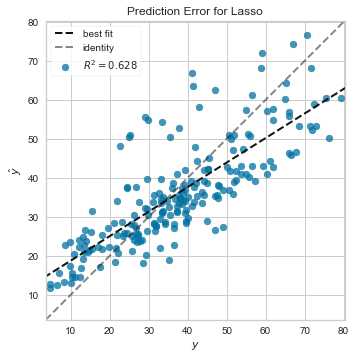

In [3]:
from sklearn.linear_model import Lasso

from yellowbrick.regressor import PredictionError

# Instantiate the linear model and visualizer
lasso = Lasso()
visualizer = PredictionError(lasso)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

## Does alpha work now?

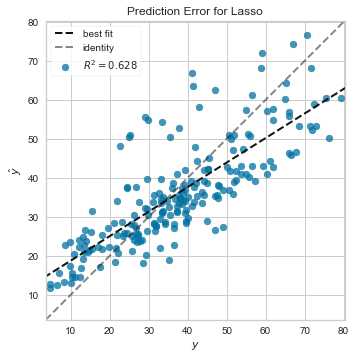

In [4]:
visualizer = PredictionError(lasso, alpha=0.1)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

In [5]:
# yellowbrick.draw
# Utilities for common matplotlib drawing procedures.
#
# Author:  Benjamin Bengfort <benjamin@bengfort.com>
# Created: Sun Aug 19 10:35:50 2018 -0400
#
# ID: draw.py [] benjamin@bengfort.com $

"""
Utilities for common matplotlib drawing procedures.
"""

##########################################################################
## Imports
##########################################################################

from yellowbrick.base import Visualizer
from yellowbrick.exceptions import YellowbrickValueError

from matplotlib import patches

import matplotlib.pyplot as plt


##########################################################################
## Legend Drawing Utilities
##########################################################################

def manual_legend(g, labels, colors, **legend_kwargs):
    """
    Adds a manual legend for a scatter plot to the visualizer where the labels
    and associated colors are drawn with circle patches instead of determining
    them from the labels of the artist objects on the axes. This helper is
    used either when there are a lot of duplicate labels, no labeled artists,
    or when the color of the legend doesn't exactly match the color in the
    figure (e.g. because of the use of transparency).

    Parameters
    ----------
    g : Visualizer or Axes object
        The graph to draw the legend on, either a Visualizer or a matplotlib
        Axes object. If None, the current axes are drawn on, but this is not
        recommended.

    labels : list of str
        The text labels to associate with the legend. Note that the labels
        will be added to the legend in the order specified.

    colors : list of colors
        A list of any valid matplotlib color reference. The number of colors
        specified must be equal to the number of labels.

    legend_kwargs : dict
        Any additional keyword arguments to pass to the legend.

    Returns
    -------
    legend: Legend artist
        The artist created by the ax.legend() call, returned for further
        manipulation if required by the caller.

    Notes
    -----
    Right now this method simply draws the patches as rectangles and cannot
    take into account the line or scatter plot properties (e.g. line style or
    marker style). It is possible to add Line2D patches to the artist that do
    add manual styles like this, which we can explore in the future.

    .. seealso:: https://matplotlib.org/gallery/text_labels_and_annotations/custom_legends.html
    """
    # Get access to the matplotlib Axes
    if isinstance(g, Visualizer):
        g = g.ax
    elif g is None:
        g = plt.gca()

    # Ensure that labels and colors are the same length to prevent odd behavior.
    if len(colors) != len(labels):
        raise YellowbrickValueError(
            "please specify the same number of colors as labels!"
        )

    # Create the legend handles with the associated colors and labels
    handles = [
        patches.Patch(color=color, label=label)
        for color, label in zip(colors, labels)
    ]

    # Return the Legend artist
    return g.legend(handles=handles, **legend_kwargs)


## Now with alpha

In [8]:
# yellowbrick.regressor.residuals
# Regressor visualizers that score residuals: prediction vs. actual data.
#
# Author:   Rebecca Bilbro <rbilbro@districtdatalabs.com>
# Author:   Benjamin Bengfort <bbengfort@districtdatalabs.com>
# Created:  Fri Jun 03 10:30:36 2016 -0700
#
# Copyright (C) 2016 2016 District Data Labs
# For license information, see LICENSE.txt
#
# ID: residuals.py [7d3f5e6] benjamin@bengfort.com $

"""
Regressor visualizers that score residuals: prediction vs. actual data.
"""

##########################################################################
## Imports
##########################################################################


import matplotlib.pyplot as plt

try:
    # Only available in Matplotlib >= 2.0.2
    from mpl_toolkits.axes_grid1 import make_axes_locatable
except ImportError:
    make_axes_locatable = None

from sklearn.model_selection import train_test_split

from yellowbrick.regressor.base import RegressionScoreVisualizer
# from yellowbrick.draw import manual_legend
from yellowbrick.style.palettes import LINE_COLOR
from yellowbrick.utils.decorators import memoized
from yellowbrick.exceptions import YellowbrickValueError
from yellowbrick.bestfit import draw_best_fit, draw_identity_line


##########################################################################
## Prediction Error Plots
##########################################################################

##########################################################################
## Prediction Error Plots
##########################################################################

class PredictionError(RegressionScoreVisualizer):
    """
    The prediction error visualizer plots the actual targets from the dataset
    against the predicted values generated by our model(s). This visualizer is
    used to dectect noise or heteroscedasticity along a range of the target
    domain.

    Parameters
    ----------

    model : a Scikit-Learn regressor
        Should be an instance of a regressor, otherwise will raise a
        YellowbrickTypeError exception on instantiation.

    ax : matplotlib Axes, default: None
        The axes to plot the figure on. If None is passed in the current axes
        will be used (or generated if required).

    shared_limits : bool, default: True
        If shared_limits is True, the range of the X and Y axis limits will
        be identical, creating a square graphic with a true 45 degree line.
        In this form, it is easier to diagnose under- or over- prediction,
        though the figure will become more sparse. To localize points, set
        shared_limits to False, but note that this will distort the figure
        and should be accounted for during analysis.

    bestfit : bool, default: True
        Draw a linear best fit line to estimate the correlation between the
        predicted and measured value of the target variable. The color of
        the bestfit line is determined by the ``line_color`` argument.

    identity: bool, default: True
        Draw the 45 degree identity line, y=x in order to better show the
        relationship or pattern of the residuals. E.g. to estimate if the
        model is over- or under- estimating the given values. The color of the
        identity line is a muted version of the ``line_color`` argument.

    point_color : color
        Defines the color of the error points; can be any matplotlib color.

    line_color : color
        Defines the color of the best fit line; can be any matplotlib color.

    alpha : float, default: 1.0
        Specify a transparency where 1 is completely opaque and 0 is completely
        transparent. This property makes densely clustered points more visible.

    kwargs : dict
        Keyword arguments that are passed to the base class and may influence
        the visualization as defined in other Visualizers.

    Examples
    --------

    >>> from yellowbrick.regressor import PredictionError
    >>> from sklearn.linear_model import Lasso
    >>> model = PredictionError(Lasso())
    >>> model.fit(X_train, y_train)
    >>> model.score(X_test, y_test)
    >>> model.poof()

    Notes
    -----

    PredictionError is a ScoreVisualizer, meaning that it wraps a model and
    its primary entry point is the `score()` method.
    """

    def __init__(self, model, ax=None, shared_limits=True,
                 bestfit=True, identity=True, alpha=1.0, **kwargs):
        # Initialize the visualizer
        super(PredictionError, self).__init__(model, ax=ax, **kwargs)

        # Visual arguments
        self.colors = {
            'point': kwargs.pop('point_color', None),
            'line': kwargs.pop('line_color', LINE_COLOR),
        }

        # Drawing arguments
        self.shared_limits = shared_limits
        self.bestfit = bestfit
        self.identity = identity
        self.alpha = alpha

    def score(self, X, y=None, **kwargs):
        """
        The score function is the hook for visual interaction. Pass in test
        data and the visualizer will create predictions on the data and
        evaluate them with respect to the test values. The evaluation will
        then be passed to draw() and the result of the estimator score will
        be returned.

        Parameters
        ----------
        X : array-like
            X (also X_test) are the dependent variables of test set to predict

        y : array-like
            y (also y_test) is the independent actual variables to score against

        Returns
        -------
        score : float
        """
        self.score_ =  self.estimator.score(X, y, **kwargs)

        y_pred = self.predict(X)
        self.draw(y, y_pred)

        return self.score_

    def draw(self, y, y_pred):
        """
        Parameters
        ----------
        y : ndarray or Series of length n
            An array or series of target or class values

        y_pred : ndarray or Series of length n
            An array or series of predicted target values

        Returns
        ------
        ax : the axis with the plotted figure
        """
        label = "$R^2 = {:0.3f}$".format(self.score_)
        self.ax.scatter(
            y,
            y_pred,
            c=self.colors['point'],
            alpha=self.alpha,
            label=label)

        # TODO If score is happening inside a loop, draw would get called multiple times.
        # Ideally we'd want the best fit line to be drawn only once
        if self.bestfit:
            draw_best_fit(
                y, y_pred, self.ax, 'linear', ls='--', lw=2,
                c=self.colors['line'], label='best fit'
            )

        # Set the axes limits based on the range of X and Y data
        # NOTE: shared_limits will be accounted for in finalize()
        # TODO: do better than add one for really small residuals
        self.ax.set_xlim(y.min()-1, y.max()+1)
        self.ax.set_ylim(y_pred.min()-1, y_pred.max()+1)

        return self.ax

    def finalize(self, **kwargs):
        """
        Finalize executes any subclass-specific axes finalization steps.
        The user calls poof and poof calls finalize.

        Parameters
        ----------
        kwargs: generic keyword arguments.
        """
        # Set the title on the plot
        self.set_title(
            'Prediction Error for {}'.format(self.name)
        )

        # Square the axes to ensure a 45 degree line
        if self.shared_limits:
            # Get the current limits
            ylim = self.ax.get_ylim()
            xlim = self.ax.get_xlim()

            # Find the range that captures all data
            bounds = (
                min(ylim[0], xlim[0]),
                max(ylim[1], xlim[1]),
            )

            # Reset the limits
            self.ax.set_xlim(bounds)
            self.ax.set_ylim(bounds)

            # Ensure the aspect ratio is square
            self.ax.set_aspect('equal', adjustable='box')

        # Draw the 45 degree line
        if self.identity:
            draw_identity_line(
                ax=self.ax, ls='--', lw=2, c=self.colors['line'],
                alpha=0.5, label="identity"
            )

        # Set the axes labels
        self.ax.set_ylabel(r'$\hat{y}$')
        self.ax.set_xlabel(r'$y$')

        # Annotate the score
        # NOTE: Couldn't get this to work so added to title instead (for now)
        # self.ax.annotate('$r^2={:0.3f}$'.format(self.score_), xy=(0,0), xytext=(0,0))

        # Set the legend
        self.ax.legend(loc='best', frameon=True)


def prediction_error(model, X, y=None, ax=None, alpha=1.0, **kwargs):
    """
    Quick method:

    Plot the actual targets from the dataset against the
    predicted values generated by our model(s).

    This helper function is a quick wrapper to utilize the PredictionError
    ScoreVisualizer for one-off analysis.

    Parameters
    ----------
    model : the Scikit-Learn estimator (should be a regressor)

    X  : ndarray or DataFrame of shape n x m
        A matrix of n instances with m features.

    y  : ndarray or Series of length n
        An array or series of target or class values.

    ax : matplotlib Axes
        The axes to plot the figure on.

    shared_limits : bool, default: True
        If shared_limits is True, the range of the X and Y axis limits will
        be identical, creating a square graphic with a true 45 degree line.
        In this form, it is easier to diagnose under- or over- prediction,
        though the figure will become more sparse. To localize points, set
        shared_limits to False, but note that this will distort the figure
        and should be accounted for during analysis.

    besfit : bool, default: True
        Draw a linear best fit line to estimate the correlation between the
        predicted and measured value of the target variable. The color of
        the bestfit line is determined by the ``line_color`` argument.

    identity: bool, default: True
        Draw the 45 degree identity line, y=x in order to better show the
        relationship or pattern of the residuals. E.g. to estimate if the
        model is over- or under- estimating the given values. The color of the
        identity line is a muted version of the ``line_color`` argument.

    point_color : color
        Defines the color of the error points; can be any matplotlib color.

    line_color : color
        Defines the color of the best fit line; can be any matplotlib color.

    alpha : float, default: 1.0
        Specify a transparency where 1 is completely opaque and 0 is completely
        transparent. This property makes densely clustered points more visible.

    kwargs : dict
        Keyword arguments that are passed to the base class and may influence
        the visualization as defined in other Visualizers.

    Returns
    -------
    ax : matplotlib Axes
        Returns the axes that the prediction error plot was drawn on.
    """
    # Instantiate the visualizer
    visualizer = PredictionError(model, ax, alpha=alpha, **kwargs)

    # Create the train and test splits
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Fit and transform the visualizer (calls draw)
    visualizer.fit(X_train, y_train, **kwargs)
    visualizer.score(X_test, y_test)
    visualizer.finalize()

    # Return the axes object on the visualizer
    return visualizer.ax


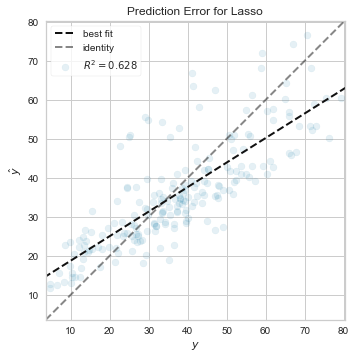

In [9]:
visualizer = PredictionError(lasso, alpha=0.1)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

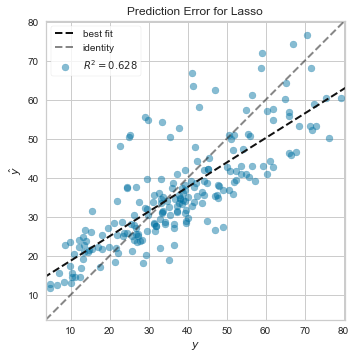

In [10]:
visualizer = PredictionError(lasso, alpha=0.475)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

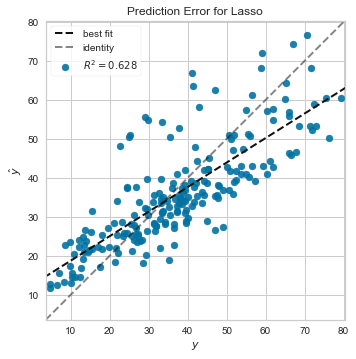

In [11]:
visualizer = PredictionError(lasso, alpha=0.9)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

## How about Residuals?

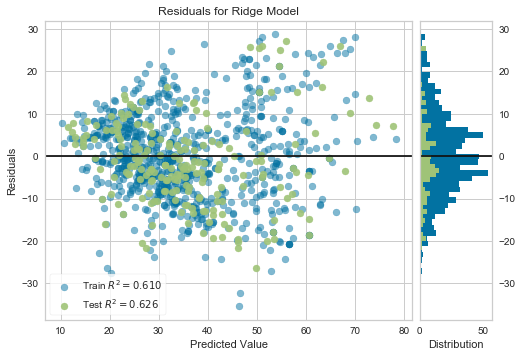

In [12]:
from sklearn.linear_model import Ridge
from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
ridge = Ridge()
visualizer = ResidualsPlot(ridge)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

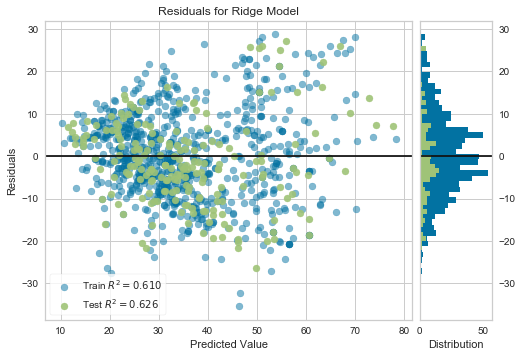

In [13]:
ridge = Ridge()
visualizer = ResidualsPlot(ridge, alpha=0.3)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

In [15]:
##########################################################################
## Residuals Plots
##########################################################################

class ResidualsPlot(RegressionScoreVisualizer):
    """
    A residual plot shows the residuals on the vertical axis and the
    independent variable on the horizontal axis.

    If the points are randomly dispersed around the horizontal axis, a linear
    regression model is appropriate for the data; otherwise, a non-linear
    model is more appropriate.

    Parameters
    ----------
    model : a Scikit-Learn regressor
        Should be an instance of a regressor, otherwise will raise a
        YellowbrickTypeError exception on instantiation.

    ax : matplotlib Axes, default: None
        The axes to plot the figure on. If None is passed in the current axes
        will be used (or generated if required).

    hist : {True, False, None, 'density', 'frequency'}, default: True
        Draw a histogram showing the distribution of the residuals on the
        right side of the figure. Requires Matplotlib >= 2.0.2.
        If set to 'density', the probability density function will be plotted.
        If set to True or 'frequency' then the frequency will be plotted.

    train_color : color, default: 'b'
        Residuals for training data are ploted with this color but also
        given an opacity of 0.5 to ensure that the test data residuals
        are more visible. Can be any matplotlib color.

    test_color : color, default: 'g'
        Residuals for test data are plotted with this color. In order to
        create generalizable models, reserved test data residuals are of
        the most analytical interest, so these points are highlighted by
        having full opacity. Can be any matplotlib color.

    line_color : color, default: dark grey
        Defines the color of the zero error line, can be any matplotlib color.

    alpha : float, default: 1.0
        Specify a transparency where 1 is completely opaque and 0 is completely
        transparent. This property makes densely clustered points more visible.

    kwargs : dict
        Keyword arguments that are passed to the base class and may influence
        the visualization as defined in other Visualizers.

    Examples
    --------

    >>> from yellowbrick.regressor import ResidualsPlot
    >>> from sklearn.linear_model import Ridge
    >>> model = ResidualsPlot(Ridge())
    >>> model.fit(X_train, y_train)
    >>> model.score(X_test, y_test)
    >>> model.poof()

    Notes
    -----
    ResidualsPlot is a ScoreVisualizer, meaning that it wraps a model and
    its primary entry point is the ``score()`` method.

    The residuals histogram feature requires matplotlib 2.0.2 or greater.
    """
    def __init__(self, model, ax=None, hist=True, train_color='b',
                 test_color='g', line_color=LINE_COLOR, alpha=1.0,
                 **kwargs):

        super(ResidualsPlot, self).__init__(model, ax=ax, **kwargs)

        # TODO: allow more scatter plot arguments for train and test points
        # See #475 (RE: ScatterPlotMixin)
        self.colors = {
            'train_point': train_color,
            'test_point': test_color,
            'line': line_color,
        }

        self.hist = hist
        if self.hist not in {True, 'density', 'frequency', None, False}:
                raise YellowbrickValueError(
                    "'{}' is an invalid argument for hist, use None, True, " \
                    "False, 'density', or 'frequency'".format(hist)
                )

        if self.hist in {True, 'density', 'frequency'}:
            self.hax # If hist is True, test the version availability

        # Store labels and colors for the legend ordered by call
        self._labels, self._colors = [], []

        self.alpha = alpha

    @memoized
    def hax(self):
        """
        Returns the histogram axes, creating it only on demand.
        """
        if make_axes_locatable is None:
            raise YellowbrickValueError((
                "residuals histogram requires matplotlib 2.0.2 or greater "
                "please upgrade matplotlib or set hist=False on the visualizer"
            ))

        divider = make_axes_locatable(self.ax)

        hax = divider.append_axes("right", size=1, pad=0.1, sharey=self.ax)
        hax.yaxis.tick_right()
        hax.grid(False, axis='x')

        return hax

    def fit(self, X, y, **kwargs):
        """
        Parameters
        ----------
        X : ndarray or DataFrame of shape n x m
            A matrix of n instances with m features

        y : ndarray or Series of length n
            An array or series of target values

        kwargs: keyword arguments passed to Scikit-Learn API.

        Returns
        -------
        self : visualizer instance
        """
        super(ResidualsPlot, self).fit(X, y, **kwargs)
        self.score(X, y, train=True)
        return self

    def score(self, X, y=None, train=False, **kwargs):
        """
        Generates predicted target values using the Scikit-Learn
        estimator.

        Parameters
        ----------
        X : array-like
            X (also X_test) are the dependent variables of test set to predict

        y : array-like
            y (also y_test) is the independent actual variables to score against

        train : boolean
            If False, `score` assumes that the residual points being plotted
            are from the test data; if True, `score` assumes the residuals
            are the train data.

        Returns
        ------
        score : float
            The score of the underlying estimator, usually the R-squared score
            for regression estimators.
        """
        score = self.estimator.score(X, y, **kwargs)
        if train:
            self.train_score_ = score
        else:
            self.test_score_ = score

        y_pred = self.predict(X)
        scores = y_pred - y
        self.draw(y_pred, scores, train=train)

        return score

    def draw(self, y_pred, residuals, train=False, **kwargs):
        """
        Draw the residuals against the predicted value for the specified split.
        It is best to draw the training split first, then the test split so
        that the test split (usually smaller) is above the training split;
        particularly if the histogram is turned on.

        Parameters
        ----------
        y_pred : ndarray or Series of length n
            An array or series of predicted target values

        residuals : ndarray or Series of length n
            An array or series of the difference between the predicted and the
            target values

        train : boolean, default: False
            If False, `draw` assumes that the residual points being plotted
            are from the test data; if True, `draw` assumes the residuals
            are the train data.

        Returns
        ------
        ax : the axis with the plotted figure
        """

        if train:
            color = self.colors['train_point']
            label = "Train $R^2 = {:0.3f}$".format(self.train_score_)
        else:
            color = self.colors['test_point']
            label = "Test $R^2 = {:0.3f}$".format(self.test_score_)

        # Update the legend information
        self._labels.append(label)
        self._colors.append(color)

        # Draw the residuals scatter plot
        self.ax.scatter(
            y_pred, residuals, c=color, alpha=self.alpha, label=label
        )

        # Add residuals histogram
        if self.hist in {True, 'frequency'}:
            self.hax.hist(residuals, bins=50, orientation="horizontal")
        elif self.hist == 'density':
            self.hax.hist(
                residuals, bins=50, orientation="horizontal", density=True
            )

        # Ensure the current axes is always the main residuals axes
        plt.sca(self.ax)
        return self.ax

    def finalize(self, **kwargs):
        """
        Finalize executes any subclass-specific axes finalization steps.
        The user calls poof and poof calls finalize.

        Parameters
        ----------
        kwargs: generic keyword arguments.
        """
        # Add the title to the plot
        self.set_title('Residuals for {} Model'.format(self.name))

        # Set the legend with full opacity patches using manual legend
        manual_legend(
            self, self._labels, self._colors, loc='best', frameon=True
        )

        # Create a full line across the figure at zero error.
        self.ax.axhline(y=0, c=self.colors['line'])

        # Set the axes labels
        self.ax.set_ylabel('Residuals')
        self.ax.set_xlabel("Predicted Value")

        # Finalize the histogram axes
        if self.hist:
            self.hax.axhline(y=0, c=self.colors['line'])
            self.hax.set_xlabel("Distribution")


def residuals_plot(model,
                   X,
                   y,
                   ax=None,
                   hist=True,
                   test_size=0.25,
                   train_color='b',
                   test_color='g',
                   line_color=LINE_COLOR,
                   random_state=None,
                   alpha=1.0,
                   **kwargs):
    """Quick method:

    Divides the dataset X, y into a train and test split (the size of the
    splits determined by test_size) then plots the training and test residuals
    agains the predicted value for the given model.

    This helper function is a quick wrapper to utilize the ResidualsPlot
    ScoreVisualizer for one-off analysis.

    Parameters
    ----------
    model : a Scikit-Learn regressor
        Should be an instance of a regressor, otherwise will raise a
        YellowbrickTypeError exception on instantiation.

    X  : ndarray or DataFrame of shape n x m
        A matrix of n instances with m features.

    y  : ndarray or Series of length n
        An array or series of target or class values.

    ax : matplotlib Axes, default: None
        The axes to plot the figure on. If None is passed in the current axes
        will be used (or generated if required).

    hist : {True, False, None, 'density', 'frequency'}, default: True
        Draw a histogram showing the distribution of the residuals on the
        right side of the figure. Requires Matplotlib >= 2.0.2.
        If set to 'density', the probability density function will be plotted.
        If set to True or 'frequency' then the frequency will be plotted.

    test_size : float, int default: 0.25
        If float, should be between 0.0 and 1.0 and represent the proportion
        of the dataset to include in the test split. If int, represents the
        absolute number of test samples.

    train_color : color, default: 'b'
        Residuals for training data are ploted with this color but also
        given an opacity of 0.5 to ensure that the test data residuals
        are more visible. Can be any matplotlib color.

    test_color : color, default: 'g'
        Residuals for test data are plotted with this color. In order to
        create generalizable models, reserved test data residuals are of
        the most analytical interest, so these points are highlighted by
        having full opacity. Can be any matplotlib color.

    line_color : color, default: dark grey
        Defines the color of the zero error line, can be any matplotlib color.

    random_state : int, RandomState instance or None, optional
        Passed to the train_test_split function.

    alpha : float, default: 1.0
        Specify a transparency where 1 is completely opaque and 0 is completely
        transparent. This property makes densely clustered points more visible.

    kwargs : dict
        Keyword arguments that are passed to the base class and may influence
        the visualization as defined in other Visualizers.

    Returns
    -------
    ax : matplotlib axes
        Returns the axes that the residuals plot was drawn on.
    """
    # Instantiate the visualizer
    visualizer = ResidualsPlot(
        model=model, ax=ax, hist=hist, train_color=train_color,
        test_color=test_color, line_color=line_color, alpha=alpha,
        **kwargs
    )

    # Create the train and test splits
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Fit and transform the visualizer (calls draw)
    visualizer.fit(X_train, y_train, **kwargs)
    visualizer.score(X_test, y_test)
    visualizer.finalize()

    # Return the axes object on the visualizer
    return visualizer.ax


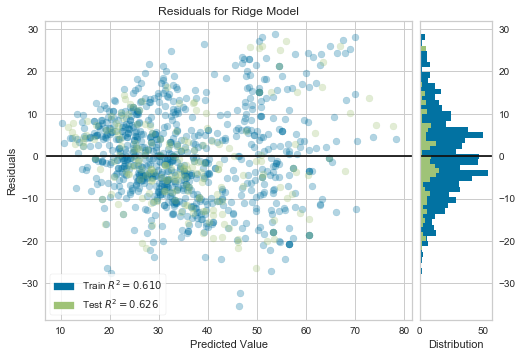

In [16]:
ridge = Ridge()
visualizer = ResidualsPlot(ridge, alpha=0.3)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

In [29]:
print(visualizer.ax.scatter())

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Tried to set a label via parameter 'y' in func 'scatter' but couldn't find such an argument.
(This is a programming error, please report to the Matplotlib list!)
  """Entry point for launching an IPython kernel.


TypeError: scatter() missing 2 required positional arguments: 'x' and 'y'